<a href="https://colab.research.google.com/github/MarcoE25/Clases-Analisis-Datos/blob/main/Ejercicio_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🐍 Curso PyBiS-Intermedio

## 🐼 Ejercicio 🐼



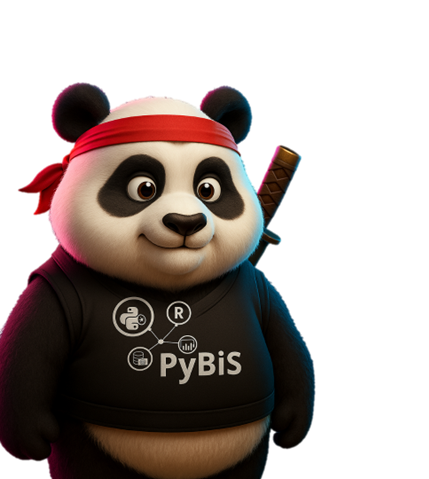

---

### Código de la clase pasada

Considerando el código que vimos la clase pasa (clase 6) tenemos que

In [2]:
# PONER EN LA PRIMER CELDA TODAS LAS LIBRERÍAS
import pandas as pd
from dateutil import parser
import datetime as dt
import random as r

# Webscraping
import urllib.request, json
from urllib.request import urlopen
from zipfile import ZipFile
import re
import requests

################################################################################
############################ CARGA DE LA INFORMACION ###########################
################################################################################
df_bank = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1.csv")
df_bank_ej = pd.read_csv("https://cursopypagina.github.io/CursoPy/Clase_1_5.csv")

df_bank_ej = df_bank_ej.rename(columns={"Fecha_Inicio_Contrato": "Fecha_Inicio"})
df_bank_ej = df_bank_ej[["Nombre_Empresa", "Ejecutivo", "Fecha_Inicio"]]

################################################################################
############################ VALORES DEL USD-EUR ###############################
################################################################################
def divisa_webs(clave):
  url = "https://www.piplatam.com/Home/filiales?country=MX"
  page = urlopen(url)
  htmlBytes = page.read()
  html = htmlBytes.decode("utf-8")
  strValorClave = html.find(clave)
  stringFiltro1 = html[strValorClave:]
  strValor = stringFiltro1.split("dblValue")[1].split("dblChange")[0]
  strValor = re.findall(r"\d+\.\d+", strValor)[0]
  return strValor

usdValor = round(float(divisa_webs("USD-MXN FIX (Banxico)")), 2)
eurValor = round(float(divisa_webs("EUR-MXN")), 2)

################################################################################
########################## LIMPIEZA Y PROCESAMIENTO ############################
################################################################################
def clean_1(df_func, tipo):
  df_func_trabajo = df_func.copy()
  df_func_trabajo['Nombre_Empresa'] = df_func_trabajo['Nombre_Empresa'].str.strip().str.title()
  df_func_trabajo["Fecha_Inicio"] = df_func_trabajo["Fecha_Inicio"].apply(lambda x: parser.parse(x))

  if tipo == "Ejecutivo":
    ############################################################################
    # Agregamos la parte donde nos quedamos solo con un ejecutivo de ventas
    df_func_trabajo = df_func_trabajo.groupby("Nombre_Empresa").agg(
        {
            "Fecha_Inicio": ['max'],
            "Ejecutivo": ['last']
        }
    )
    df_func_trabajo = df_func_trabajo.reset_index()
    df_func_trabajo.columns = ['Nombre_Empresa', 'Fecha_Inicio', 'Ejecutivo']
    return df_func_trabajo
  elif tipo == "General":
    df_func_trabajo['Fecha_Fin'] = df_func_trabajo['Fecha_Fin'].fillna('1900-01-01')
    df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].fillna(0)
    df_func_trabajo['Plazo'] = df_func_trabajo['Plazo'].astype(int)

    df_func_trabajo['Fecha_Fin'] = df_func_trabajo['Fecha_Fin'].apply(lambda x: parser.parse(x))
    df_func_trabajo['Operacion'] = df_func_trabajo['Operacion'].str.split("-").apply(lambda x: x[1])

    fechaReporte = dt.datetime.today() - dt.timedelta(days = 1)
    fechaReporte = dt.datetime.strftime(fechaReporte, "%Y-%m-%d")
    df_func_trabajo['Fecha_Reporte'] = fechaReporte

    # Columnas condicionales
    zonas = ["Norte", "Sur", "Centro"]
    df_func_trabajo['Zonas'] = [r.choice(zonas) for i in range(len(df_func_trabajo))]

    def valorizador(divisa):
      if divisa == "USD":
        return usdValor
      elif divisa == "EUR":
        return eurValor
      else:
        return 1
    df_func_trabajo['Divisa_Valor'] = df_func_trabajo['Divisa'].apply(valorizador)
    df_func_trabajo['Monto_Credito'] = df_func_trabajo['Monto_Credito'] * df_func_trabajo['Divisa_Valor']
    del df_func_trabajo['Divisa_Valor']

    return df_func_trabajo
  else:
    print("⚠️Nombre inválido⚠️")

################################################################################
##################### APLICAMOS LA FUNCION DE LIMPIEZA #########################
################################################################################
df_bank_clean = clean_1(df_bank, "General")
df_bank_clean_ej = clean_1(df_bank_ej, "Ejecutivo")

* 📂 Se cargan información de CSV en la web 🌐

* 🧹 Realizamos un proceso de limpieza, ➕ agregamos columnas nuevas, 🤖 hacemos web scraping para obtener el valor del 💵 dólar y del 💶 euro, y otros procesamientos más ⚙️

* ✅ Al final del código anterior, tenemos ya datasets limpios 🧾✨

Una vez que la información ya está limpia 🧽, podemos empezar entonces con el proceso del análisis de datos.

De tal suerte:

### 1. Une los dos dataset para obtener un solo conjunto de datos con la información consolidada

In [8]:
#del df_bank_clean_ej["Fecha_Inicio"]
#df_bank_clean
df_mergiado=df_bank_clean.merge(df_bank_clean_ej, on="Nombre_Empresa", how="left")
df_mergiado

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-17,Centro,Luis Manuel Ana María Vera Domínguez
1,Walmart De México,1.286674e+08,USD,100001,2017-04-10,2022-02-18,1775,2025-09-17,Norte,Eloisa Salinas Aguilar
2,Liverpool,2.145301e+08,EUR,100002,2017-04-21,1900-01-01,0,2025-09-17,Norte,Dr. Virginia Pelayo
3,Grupo Lala,2.374028e+07,USD,100003,2023-11-24,1900-01-01,0,2025-09-17,Centro,Juana Antonia Lira Samaniego
4,Femsa,1.541927e+08,EUR,100004,2024-10-30,1900-01-01,0,2025-09-17,Norte,Gabino Mariano Laureano Puente
...,...,...,...,...,...,...,...,...,...,...
9995,Bbva México,7.649614e+06,MXN,109995,2021-01-02,2023-03-01,788,2025-09-17,Norte,Víctor Durán de la Crúz
9996,Soriana,1.578366e+06,MXN,109996,2017-02-28,2022-02-12,1810,2025-09-17,Sur,Alfonso Natalia Sevilla
9997,Walmart De México,2.057032e+06,MXN,109997,2020-05-19,1900-01-01,0,2025-09-17,Sur,Eloisa Salinas Aguilar
9998,Grupo Bimbo,6.555259e+06,MXN,109998,2017-05-13,2019-12-24,955,2025-09-17,Norte,Luis Manuel Ana María Vera Domínguez


### 2. Responde con código las siguientes preguntas

1. ¿Cuánto nos deben por zona?
2. ¿Cuánto debe en total bimbo?
3. ¿Cuánto nos deben por divisa?

In [9]:
df_mergiado_zonas=df_mergiado.groupby("Zonas")["Monto_Credito"].sum().reset_index()
df_mergiado_zonas["Monto_Credito"]=df_mergiado_zonas["Monto_Credito"].apply(lambda x: f"{x:,}")
df_mergiado_zonas

,Zonas,Monto_Credito
0,Centro,"230,353,449,886.93298"
1,Norte,"228,093,843,879.8671"
2,Sur,"243,484,475,855.4997"


In [12]:
df_bimbo=df_mergiado.query("Nombre_Empresa == 'Grupo Bimbo'")
total_deuda=df_bimbo["Monto_Credito"].sum()
print(total_deuda)

44832019372.5987


In [14]:
df_divisa=df_mergiado.groupby("Divisa")["Monto_Credito"].sum().apply(lambda x: f"{x:,}").reset_index()
df_divisa

,Divisa,Monto_Credito
0,EUR,"371,447,124,691.8558"
1,MXN,"16,501,540,339.68"
2,USD,"313,983,104,590.764"


### Crea un función para saber cuánto debe cada empresa

* Si te diste cuenta el código solución del ejercicio anterior es el mismo si analizaramos, por ejemplo, a Alsea en vez de bimbo, así, tu deber será implementar una función para que obtengas el monto de la deuda de la empresa que queramos

In [22]:
def deuda(empresa):
  df_deuda_empresa=df_mergiado.query("Nombre_Empresa == @empresa")
  return df_deuda_empresa
deuda("Grupo Bimbo")

,Nombre_Empresa,Monto_Credito,Divisa,Operacion,Fecha_Inicio,Fecha_Fin,Plazo,Fecha_Reporte,Zonas,Ejecutivo
0,Grupo Bimbo,4.117590e+06,MXN,100000,2019-08-27,2023-04-24,1336,2025-09-17,Centro,Luis Manuel Ana María Vera Domínguez
8,Grupo Bimbo,1.857065e+08,EUR,100008,2022-12-25,1900-01-01,0,2025-09-17,Norte,Luis Manuel Ana María Vera Domínguez
9,Grupo Bimbo,7.982346e+06,EUR,100009,2024-08-05,1900-01-01,0,2025-09-17,Centro,Luis Manuel Ana María Vera Domínguez
11,Grupo Bimbo,1.945741e+08,EUR,100011,2020-03-23,1900-01-01,0,2025-09-17,Sur,Luis Manuel Ana María Vera Domínguez
40,Grupo Bimbo,9.510346e+07,EUR,100040,2024-08-08,1900-01-01,0,2025-09-17,Sur,Luis Manuel Ana María Vera Domínguez
...,...,...,...,...,...,...,...,...,...,...
9968,Grupo Bimbo,7.636317e+07,USD,109968,2017-04-27,2021-07-16,1541,2025-09-17,Sur,Luis Manuel Ana María Vera Domínguez
9969,Grupo Bimbo,1.291838e+06,MXN,109969,2021-04-19,1900-01-01,0,2025-09-17,Sur,Luis Manuel Ana María Vera Domínguez
9981,Grupo Bimbo,9.590213e+07,USD,109981,2015-10-20,1900-01-01,0,2025-09-17,Norte,Luis Manuel Ana María Vera Domínguez
9988,Grupo Bimbo,9.586326e+06,MXN,109988,2021-11-17,1900-01-01,0,2025-09-17,Centro,Luis Manuel Ana María Vera Domínguez


### Crea un columna condicional con tasas

Para ello:

1. Usa el código de ejemplo

```python
banxico_token = "Coloca aqui tu toke de banxico"

fecha = "coloca la fecha de interes"
url_tiie = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43718/datos/{fecha}/{fecha}"
headers = {"Bmx-Token": banxico_token}
r_tiie = requests.get(url_tiie, headers=headers).json()
try:
    tiie_28 = float(r_tiie["bmx"]["series"][0]["datos"][0]["dato"])
except:
    tiie_28 = None

# El resultado sera la tasa de referencia para creditos en pesos  
tiie_28
```

En este paso lo único que debes de hacer es obtener tu token en la página de banxico: [Link](https://www.banxico.org.mx/SieAPIRest/service/v1/token)

2. Usa el siguiente código para hacer webscraping con pandas y obtener el valor de la tasa de referencia SOFR ON para los créditos en dólares:

```python
lista_sofr_usd_base = pd.read_html('https://fred.stlouisfed.org/series/SOFR')
sofr_usd_base = lista_sofr_usd_base[0]

# El resultado final es un dataframe sucio
sofr_usd_base
```

El dataframe resultante sucio es de la forma

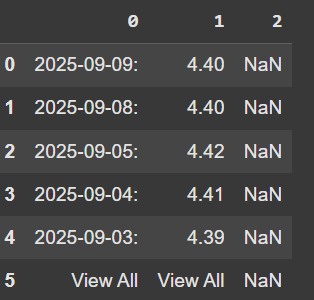

Dependiendo del día en el cual quieras hacer el reporte-ejercicio, es que seleccionarás su valor asociado. Por ejemplo, si quieres quieres obtener información de los créditos del día ``2025-09-09`` entonces tu objetivo final es obtener solo el valor 4.40, que corresponde, justamente, al valor de la tasa de referencia SOFR ON para los créditos en dólares del 9 de septiembre.

3. Lo mismo que en el punto anterior pero para la tasa de referencia Euribor:

```python
lista_euribor_base = pd.read_html('https://www.euribor-rates.eu/es/tipos-euribor-actualmente/2/euribor-valor-3-meses/#google_vignette')[0]

## Dataframe sucio
lista_euribor_base
```

---

Con lo anterior tendrás algo como:

```python
# cifras de ejemplo
tiie_28 = 13.5
sofr_on = 5.3
euribor = 2.03
```

con esa información serás capaz de agregar una columna condicional de la forma:

Divisa | Tasa
---|---
USD| 5.3
USD| 5.3
MXN| 13.5
EUR| 2.03

Etcétera

In [25]:
banxico_token = "c65ada96cdbc98356e154824f3ff0a07863c5c7ce9a7a78fb0360f84160426d0"

fecha = "coloca la fecha de interes"
url_tiie = f"https://www.banxico.org.mx/SieAPIRest/service/v1/series/SF43718/datos/{fecha}/{fecha}"
headers = {"Bmx-Token": banxico_token}
r_tiie = requests.get(url_tiie, headers=headers).json()
try:
    tiie_28 = float(r_tiie["bmx"]["series"][0]["datos"][0]["dato"])
except:
    tiie_28 = None

# El resultado sera la tasa de referencia para creditos en pesos
tiie_28

lista_euribor_base = pd.read_html('https://www.euribor-rates.eu/es/tipos-euribor-actualmente/2/euribor-valor-3-meses/#google_vignette')[0]

## Dataframe sucio
lista_euribor_base


,0,1
0,17/09/2025,"2,024 %"
1,16/09/2025,"2,015 %"
2,15/09/2025,"2,033 %"
3,12/09/2025,"2,000 %"
4,11/09/2025,"2,014 %"
5,10/09/2025,"2,029 %"
6,09/09/2025,"2,029 %"
7,08/09/2025,"2,034 %"
8,05/09/2025,"2,053 %"
9,04/09/2025,"2,078 %"
